In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
from datetime import timezone, datetime

# 1. Data Loading

In [73]:
imputedMeasurementsDf = pd.read_csv('../../../../Data/ProcessedData/KnnImputed/measurementsImputedByKnn.csv')
measurementsDf = pd.read_csv('../../../../Data/RawData/rawMeasurementsFilteredBySensors.csv')

In [74]:
measurementsDf.head()

,time,T,Rn,H,P,CO2,sensor_id
0,2020-07-14T14:00:00.000Z,31.300000,NaN,44.475000,NaN,567.750000,D0001
1,2020-07-14T15:00:00.000Z,31.333333,NaN,45.505556,NaN,636.361111,D0001
2,2020-07-14T16:00:00.000Z,31.451429,NaN,47.145714,NaN,734.000000,D0001
3,2020-07-14T17:00:00.000Z,31.161765,NaN,36.000000,NaN,461.529412,D0001
4,2020-07-14T18:00:00.000Z,31.008333,NaN,28.436111,NaN,400.000000,D0001


In [75]:
dateTimeDf = pd.DataFrame(measurementsDf['time'])

In [76]:
def iso8601ToDatetime():
    for i in range(len(dateTimeDf['time'])):
        timeContainer  = dateTimeDf['time'][i].replace('.000','')
        timeContainer = datetime.strptime(timeContainer, "%Y-%m-%dT%H:%M:%SZ")
        timeContainer = int(round(timeContainer.timestamp()))
        timeContainer = datetime.fromtimestamp(timeContainer)
        dateTimeDf['time'][i] = timeContainer

In [77]:
%%time

iso8601ToDatetime()

CPU times: total: 8.22 s
Wall time: 8.28 s


In [78]:
measurementsDf = dateTimeDf.join(imputedMeasurementsDf.drop(['day','month','hour'],axis = 1))


In [108]:
plotDf =  measurementsDf.drop(['sensor_id'],axis = 1)

In [109]:
plotDf

,time,T,Rn,H,P,CO2
0,2020-07-14 14:00:00,31.300000,1001.448424,44.475000,101.565847,567.750000
1,2020-07-14 15:00:00,31.333333,588.154974,45.505556,101.632854,636.361111
2,2020-07-14 16:00:00,31.451429,0.100000,47.145714,101.539128,734.000000
3,2020-07-14 17:00:00,31.161765,1042.843803,36.000000,101.501998,461.529412
4,2020-07-14 18:00:00,31.008333,1585.713833,28.436111,101.567130,400.000000
...,...,...,...,...,...,...
115629,2021-12-31 19:00:00,29.792673,616.640000,50.156364,102.653100,97.200000
115630,2021-12-31 20:00:00,29.951673,541.380000,48.047273,102.273400,97.800000
115631,2021-12-31 21:00:00,30.329218,544.167273,53.847273,102.199727,97.181818
115632,2021-12-31 22:00:00,29.511200,590.666000,44.097576,102.140000,98.100000


<AxesSubplot:>

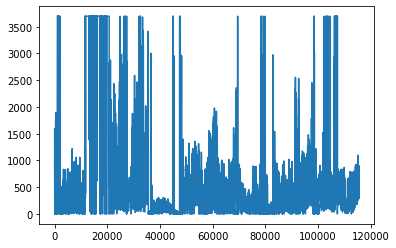

In [112]:
plotDf['Rn'].plot()

# 2. Data Plot

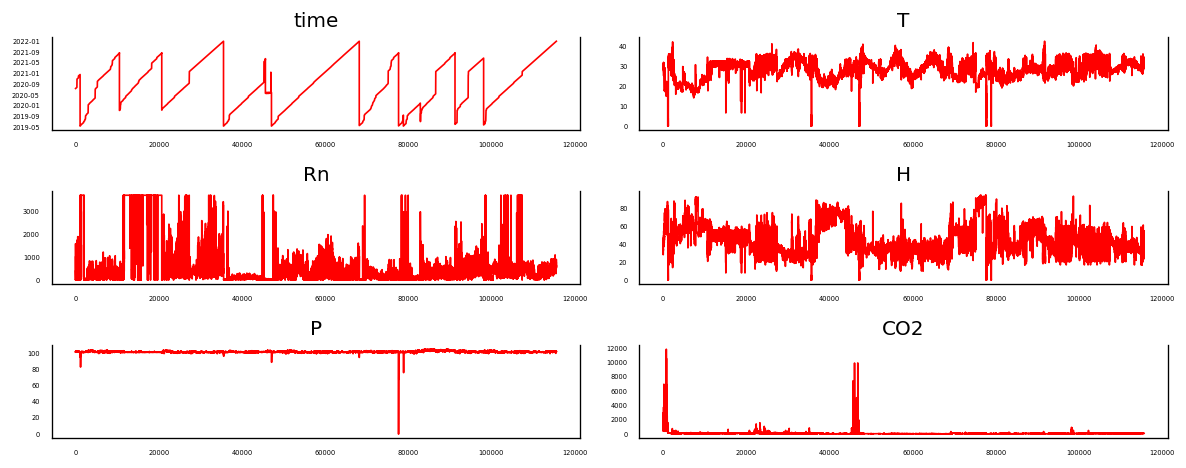

In [111]:
fig, axes = plt.subplots(nrows=3, ncols=2 ,dpi=120, figsize=(10,6))
for i, ax in enumerate((axes.flatten())):
    data = plotDf[plotDf.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(plotDf.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)
    
plt.tight_layout();


In [69]:
axes.flatten()

array([<AxesSubplot:title={'center':'T'}>,
       <AxesSubplot:title={'center':'Rn'}>,
       <AxesSubplot:title={'center':'H'}>,
       <AxesSubplot:title={'center':'P'}>,
       <AxesSubplot:title={'center':'CO2'}>, <AxesSubplot:>], dtype=object)

In [115]:
ad_fuller_result_1 = adfuller(plotDf['T'].diff()[1:])

print('Temperature')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(plotDf['Rn'].diff()[1:])

print('Radon')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

ad_fuller_result_3 = adfuller(plotDf['H'].diff()[1:])

print('Humidity')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

ad_fuller_result_4 = adfuller(plotDf['P'].diff()[1:])

print('Pressure')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')

ad_fuller_result_5= adfuller(plotDf['CO2'].diff()[1:])

print('CO2')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

Temperature
ADF Statistic: -48.17445740431627
p-value: 0.0

---------------------

Radon
ADF Statistic: -58.31529307473351
p-value: 0.0
Humidity
ADF Statistic: -53.57172303826772
p-value: 0.0
Pressure
ADF Statistic: -50.76910299858513
p-value: 0.0
CO2
ADF Statistic: -57.59552754365333
p-value: 0.0
